## Assignment

1. Consider the two variables: *TOTAL_REVENUE* and *TOTAL_EXPENDITURE*. Do these variables have outlier values?
2. If you detect outliers in the *TOTAL_REVENUE* and *TOTAL_EXPENDITURE* variables, apply the techniques you learned in this checkpoint to eliminate them and validate that there's no outlier values after you handled them.
3. Create another variable by subtracting the original *TOTAL_EXPENDITURE* from *TOTAL_REVENUE* (before you eliminated the outliers). You can think of it as a kind of budget deficit in education. Do you find any outlier values in this new variable? If so, eliminate them using the technique you think most suitable.
4. Now create another variable by subtracting the *TOTAL_EXPENDITURE* from *TOTAL_REVENUE*. This time, use the outlier eliminated versions of *TOTAL_EXPENDITURE* from *TOTAL_REVENUE*. In this newly created variable, can you find any outliers? If so, eliminate them.
5. Compare some basic descriptive statistics of the budget variables you end up with in the 3rd and the 4th questions. Do you see any differences?
6. If our variable of interest is the budget deficit variable, which method do you think is the appropriate in dealing with the outliers in this variable: the method in the 3rd question or the one in the 4th question?

In [86]:
import pandas as pd
import numpy as np 
import pandas_profiling
from sqlalchemy import create_engine
import warnings 

warnings.filterwarnings('ignore')

In [141]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

edu = pd.read_sql_query('select * from useducation',con=engine)

engine.dispose()

In [142]:
edu.profile_report()

In [88]:
df = edu.copy()

fill_list = ["ENROLL", "TOTAL_REVENUE", "FEDERAL_REVENUE", 
             "STATE_REVENUE", "LOCAL_REVENUE", "TOTAL_EXPENDITURE", 
             "INSTRUCTION_EXPENDITURE", "SUPPORT_SERVICES_EXPENDITURE",
             "OTHER_EXPENDITURE", "CAPITAL_OUTLAY_EXPENDITURE", "GRADES_PK_G", 
             "GRADES_KG_G", "GRADES_4_G", "GRADES_8_G", "GRADES_12_G", "GRADES_1_8_G", 
             "GRADES_9_12_G", "GRADES_ALL_G"]

states = edu["STATE"].unique()

for state in states:
    df.loc[edu["STATE"] == state, fill_list] = df.loc[edu["STATE"] == state, fill_list].interpolate()

df.dropna(inplace=True)

In [90]:
#df.isnull().sum()/df.isnull().count()

### 1. Consider the two variables: TOTAL_REVENUE and TOTAL_EXPENDITURE. Do these variables have outlier values?

Yes. There are many outliers for both variables. 

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

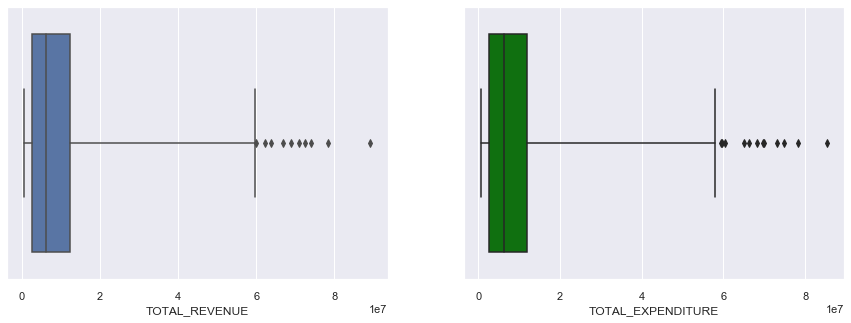

In [91]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
ax = sns.boxplot(x=df["TOTAL_REVENUE"], whis=5)

plt.subplot(1,2,2)
ax = sns.boxplot(x=df["TOTAL_EXPENDITURE"], whis=5, color="green")

plt.show()

### 2. If you detect outliers in the *TOTAL_REVENUE* and *TOTAL_EXPENDITURE* variables, apply the techniques you learned in this checkpoint to eliminate them and validate that there's no outlier values after you handled them.

I chose to winsorize outliers by setting the values of lowest and highest end the distribution to the value of the 0 and 95th percentile, respectively. By doing so, outliers were successfully removed from these two variables.

In [118]:
from scipy.stats.mstats import winsorize

win_totrev = winsorize(df['TOTAL_REVENUE'], (0, 0.05))
win_totexp = winsorize(df['TOTAL_EXPENDITURE'], (0, 0.05))

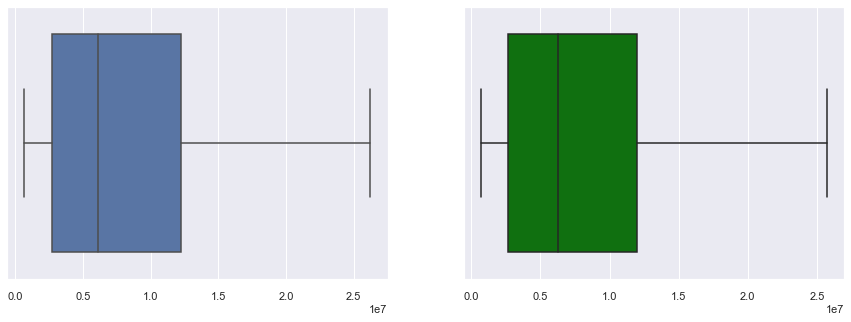

In [93]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
ax = sns.boxplot(x=win_totrev, whis=5)

plt.subplot(1,2,2)
ax = sns.boxplot(x=win_totexp, whis=5, color="green")

plt.show()

### 3. Create another variable by subtracting the original *TOTAL_EXPENDITURE* from *TOTAL_REVENUE* (before you eliminated the outliers). You can think of it as a kind of budget deficit in education. Do you find any outlier values in this new variable? If so, eliminate them using the technique you think most suitable.

The new varaible does have many outliers in both directions. After applying winsorization with (10th and 94th percentiles), outliers were removed. 

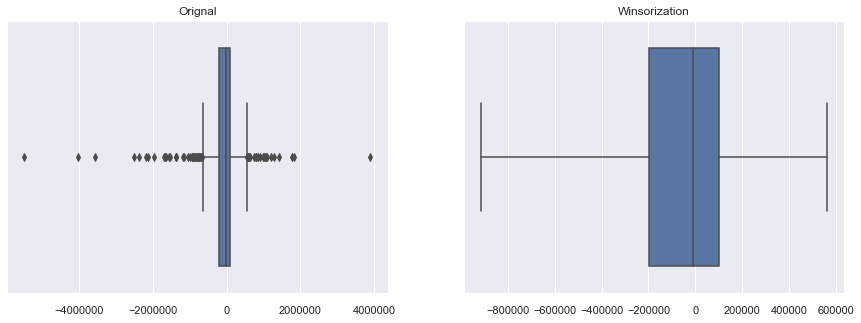

In [139]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
edu_budg = df["TOTAL_REVENUE"] - df["TOTAL_EXPENDITURE"]
ax = sns.boxplot(x=edu_budg1)
plt.title("Orignal")

plt.subplot(1,2,2)

win_edubudg1 = winsorize(edu_budg1, (0.05, 0.05))
ax = sns.boxplot(x=win_edubug1, whis=5)
plt.title("Winsorization")

plt.show()

### 4. Now create another variable by subtracting the *TOTAL_EXPENDITURE* from *TOTAL_REVENUE*. This time, use the outlier eliminated versions of *TOTAL_EXPENDITURE* from *TOTAL_REVENUE*. In this newly created variable, can you find any outliers? If so, eliminate them.

Yes. Most of them were successfully removed by winsorization by using the same criteria as Q3. 

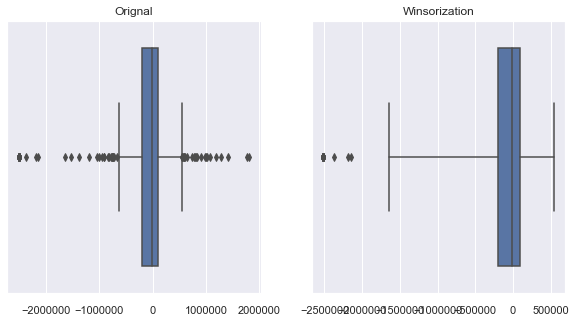

In [133]:
edu_budg2 = win_totrev - win_totexp

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
ax = sns.boxplot(x=edu_budg2)
plt.title('Orignal')

plt.subplot(1,2,2)
win_edubudg2 = winsorize(edu_budg2, (0.05, 0.05))
ax = sns.boxplot(x=win_edubudg2, whis=5)
plt.title('Winsorization')

plt.show()

### 5. Compare some basic descriptive statistics of the budget variables you end up with in the 3rd and the 4th questions. Do you see any differences?

Yes. Their descriptive statistics are quite different for winsorized_budget1 and winsorized_budget2:
+ mean: -58733 vs. -172053
+ median: -8873 vs. -12824
+ min: -913765 vs. -2518429
+ max: 560511 vs. 540055

In [140]:
pd.DataFrame({"original_budget": edu_budg, "winsorized_budget1": win_edubudg1, 
             "winsorized_budget2": win_edubudg2}). describe()

,original_budget,winsorized_budget1,winsorized_budget2
count,4.660000e+02,466.000000,4.660000e+02
mean,-8.094882e+04,-58733.012876,-1.720532e+05
std,6.144222e+05,341300.816505,6.509561e+05
min,-5.487742e+06,-913765.000000,-2.518429e+06
25%,-1.965748e+05,-196574.750000,-2.047750e+05
50%,-8.872500e+03,-8872.500000,-1.282350e+04
75%,1.013948e+05,101394.750000,9.826300e+04
max,3.897129e+06,560511.000000,5.400550e+05


### 6. If our variable of interest is the budget deficit variable, which method do you think is the appropriate in dealing with the outliers in this variable: the method in the 3rd question or the one in the 4th question?

For the new variable of interest, it's more appropriate to remove outliers from orginal data first, and then compute the new variable and then deal with its outliers. Therefore, the method in the 4th quesion is more suitable.